<a href="https://colab.research.google.com/github/changge1997/Spam-Message-Detection/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # numerical computing 
import pandas as pd # data analysis, working with DataFrames
import matplotlib.pyplot as plt # visualizations
from wordcloud import WordCloud
import seaborn as sns # visulizations ++
import tensorflow as tf # our main library, deep learning modellign
from tensorflow import keras # keras library
from keras import layers # for creating layers

## **Load the dataset**

In [2]:
# read spam dataset into a a Pandas Dataframe
data = pd.read_csv("https://raw.githubusercontent.com/changge1997/Spam-Message-Detection/main/spam.csv", encoding = "ISO-8859-1") 

In [3]:
# show first few lines of spam data set
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# drop unnecessary columns
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [5]:
# rename columns to something better
data = data.rename(columns={'v1':'label', 'v2':'message'})

In [6]:
data['label_in_num'] = data['label'].map({'ham':0,'spam':1})

In [7]:
data.head()

,label,message,label_in_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<Axes: xlabel='label', ylabel='count'>

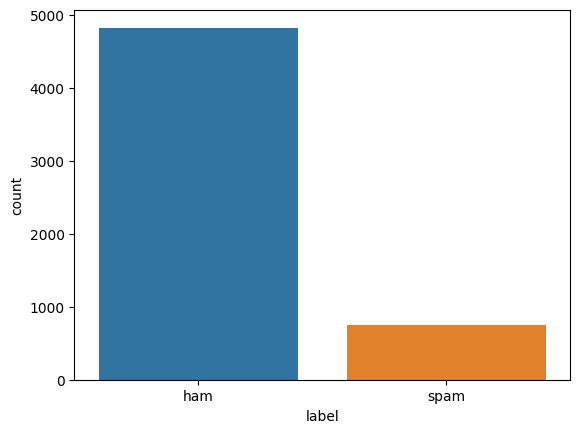

In [8]:
sns.countplot(x=data['label']) # countplot for label

In [9]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [10]:
text_words_lengths = [len(data.loc[i]['message'].split()) for i in range(0, len(data))]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))
print('we have ' + str(total_length) + ' words in our Dataframe')
print('the average word count in every scentence is ' + str(text_words_mean))

we have 86335 words in our Dataframe
the average word count in every scentence is 15


## **Data Visualization**

In [11]:
# make two arrays, one to indicate spam and another to store the sms
spam_arr = data['label'].tolist()
data_list = data['message'].tolist()

# separate the data set into spam and ham
spam = []
ham = []

for i in range(len(spam_arr)):
  if spam_arr[i] == 'ham':
    ham.append(data_list[i])
  else:
    spam.append(data_list[i])

### **spam data**

In [12]:
# here we're going to use wordcloud to visualise text data

# however, we don't want a list for our text data. we want it to be a single text data
# what this code does is every list element is joined with a space
text = ' '.join(spam)

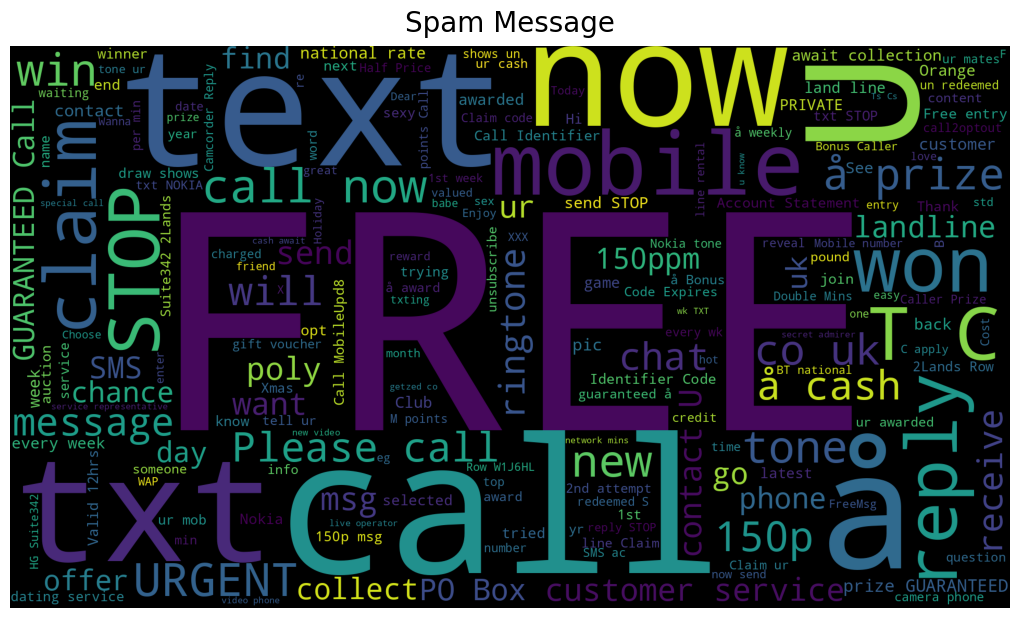

In [13]:
# now we can use wordcloud

wordcloud = WordCloud(width=1920, height=1080).generate(text)
# visualise the wordcloud
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
# don't show axis
plt.axis('off')
# don't put padding
plt.tight_layout(pad=0)
plt.title("Spam Message", fontdict={'size': 20, 'verticalalignment': 'bottom'})
plt.show()

In [14]:
!mkdir -p data
wordcloud.to_file("./data/spam.png")

### **ham data**

In [15]:
# here we're going to use wordcloud to visualise text data

# however, we don't want a list for our text data. we want it to be a single text data
# what this code does is every list element is joined with a space
text = ' '.join(ham)

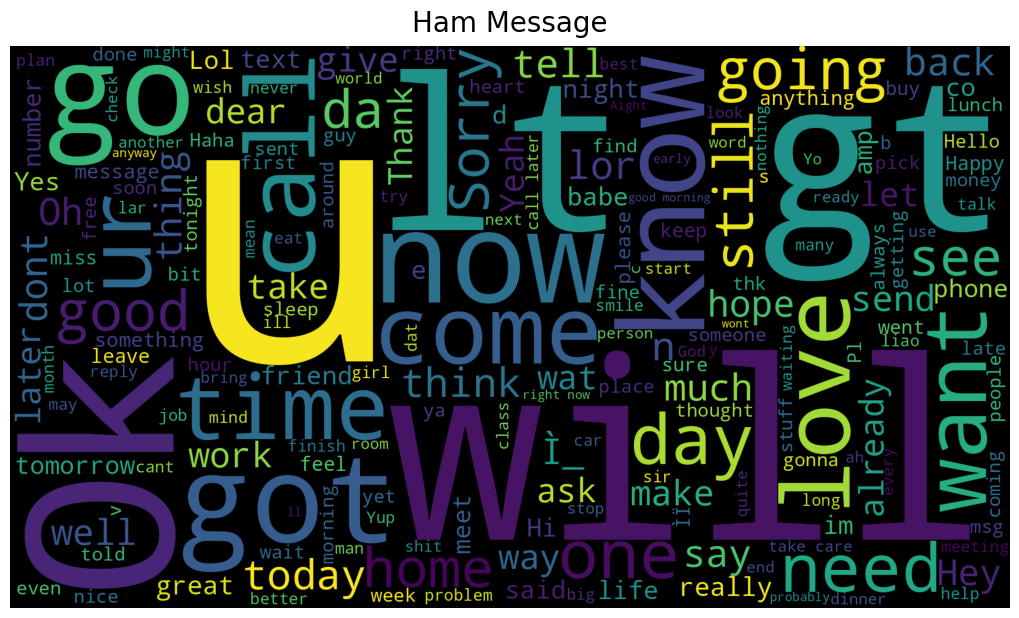

In [16]:
# now we can use wordcloud
wordcloud = WordCloud(width=1920, height=1080).generate(text)
# visualise the wordcloud
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
# don't show axis
plt.axis('off')
# don't put padding
plt.tight_layout(pad=0)
plt.title("Ham Message", fontdict={'size': 20, 'verticalalignment': 'bottom'})
plt.show()

In [17]:
!mkdir -p data
wordcloud.to_file("./data/ham.png")

## **Data Preprocessing**

In [18]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(data['message']), np.asanyarray(data['label_in_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test)

(4457, 1115)

In [19]:
MAXTOKENS = total_length
OUTPUTLEN = text_words_mean

text_vec = layers.TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)

text_vec.adapt(X_train)

In [20]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [21]:
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])    

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train and test data
    '''
    history = model.fit(X_train,
              y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
             initial_epoch=0
             )
    return history

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall,
                         'f1-score':f1}
    
    return model_results_dict

In [23]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) # Input layer, string type(text)
vec_layer = text_vec(input_layer) # text vectorization layer(built previous lines)
embedding_layer_model = embedding_layer(vec_layer) # word embedding layer
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model) # Bidirectional-LSTM, 64 units
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm) # Flatten layer for enering in dense layers
dropout = layers.Dropout(.1)(flatten) # drop out layer
x = layers.Dense(32, activation='relu')(dropout) # Dense layer
output_layer = layers.Dense(1, activation='sigmoid')(x) # output layer
model_BiLSTM = keras.Model(input_layer, output_layer) # final model

In [24]:

compile_model(model_BiLSTM) # compile the model

result = fit_model(model_BiLSTM, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 51s 302ms/step - loss: 0.1679 - accuracy: 0.9430 - val_loss: 0.0620 - val_accuracy: 0.9794
Epoch 2/5
140/140 [==============================] - 42s 298ms/step - loss: 0.0285 - accuracy: 0.9921 - val_loss: 0.0611 - val_accuracy: 0.9812
Epoch 3/5
140/140 [==============================] - 46s 325ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0644 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 42s 300ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0744 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 42s 303ms/step - loss: 1.0284e-04 - accuracy: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.9839


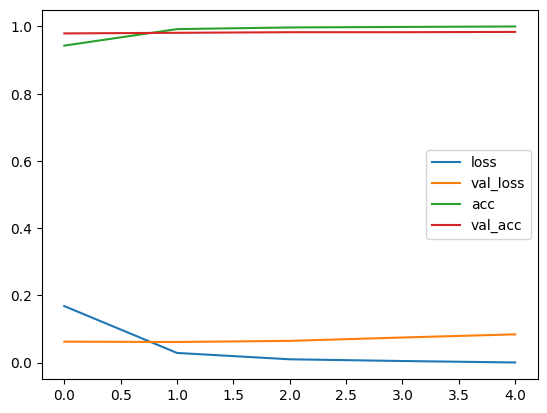

In [26]:
# Plot loss per iteration
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.plot(result.history['accuracy'], label='acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()

In [31]:
model_BiLSTM_results = pd.DataFrame({'Bidirectional-LSTM':evaluate_model(model_BiLSTM, X_test, y_test)}).transpose()
model_BiLSTM_results

35/35 [==============================] - 1s 36ms/step


,accuracy,f1-score,precision,recall
Bidirectional-LSTM,0.983857,0.93617,0.956522,0.916667
